# Lip Reading

In [29]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import keras
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers.wrappers import TimeDistributed
import pandas
import os
import scipy
from PIL import Image
import matplotlib.pyplot as plt
import PIL

# Read the dataset

In [30]:
class MasterReader(object):
    def __init__(self, nc, ne, bs, lr):
        self.num_classes = nc
        self.num_epochs = ne
        self.batch_size = bs
        self.learning_rate = lr
        self.MAX_WIDTH = 90
        self.MAX_HEIGHT = 90
        self.max_seq_length = 20


    def load_data(self):
        people = ['F01', 'F02', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'F11', 'M01', 'M02', 'M04', 'M07',
                      'M08']
        data_types = [ 'words']#, 'phrases'
        folder_enum = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']

        UNSEEN_VALIDATION_SPLIT = ['F05']
        UNSEEN_TEST_SPLIT = ['F06']
        X_train = []
        y_train = []
        X_val = []
        y_val = []
        X_test = []
        y_test = []
        other=[]

        directory = '/data/cropped'
        for person_id in people:
            instance_index = 0
            for data_type in data_types:
                for word_index, word in enumerate(folder_enum):
                    print("Instance ",instance_index)
                    for iteration in folder_enum:
                        path = os.path.join(directory, person_id, data_type, word, iteration)
                        filelist = sorted(os.listdir(path + '/'))
                        sequence = []
                        for img_name in filelist:
                            if img_name.startswith('color'):
                                image = Image.open(path + '/' + img_name)
                                image = image.convert('RGB')
                                image = image.resize((self.MAX_WIDTH, self.MAX_HEIGHT), PIL.Image.ANTIALIAS)
                                sequence.append(image)
                        pad_array = [np.zeros((self.MAX_WIDTH, self.MAX_HEIGHT,3))]
                        sequence.extend(pad_array * (self.max_seq_length - len(sequence)))
                        sequence = np.stack(sequence, axis=0)
                            
                        if person_id in UNSEEN_TEST_SPLIT:
                            X_test.append(sequence)
                            y_test.append(instance_index)
                        elif person_id in UNSEEN_VALIDATION_SPLIT:
                            X_val.append(sequence)
                            y_val.append(instance_index)
                        else:
                            a=sequence
                            X_train.append(a)
                            y_train.append(instance_index)
                    instance_index += 1
            print("......")
            print('Finished reading images for person ' + person_id)

        print('Finished reading images.')
            #print(np.shape(X_train))

        X_train = np.array(X_train[:])
        X_val = np.array(X_val)
        X_test = np.array(X_test)

        print('Finished stacking the data into the right dimensions. About to start saving to disk...')

            #if not os.path.isdir(data_dir):
            #    os.mkdir(data_dir)
            #np.save('X_train', X_train)
            # np.save('y_train', np.array(y_train))
            # np.save('X_val', X_val)
            # np.save('y_val', np.array(y_val))
            # np.save('X_test', X_test)
            # np.save('y_test', np.array(y_test))
            # print('Finished saving all data to disk. Returing.')

        return X_train, y_train, X_val, y_val, X_test, y_test
    def training_generator(self):

        X_train, y_train, X_val, y_val, X_test, y_test = self.load_data()

        while True:
            for i in range(int(np.shape(X_train)[0] / self.batch_size)):
                x = X_train[i * self.batch_size: (i + 1) * self.batch_size]
                y = y_train[i * self.batch_size: (i + 1) * self.batch_size]
                one_hot_labels = keras.utils.to_categorical(y, num_classes=self.num_classes)
                yield (x, one_hot_labels)

    def create_model(self):

        np.random.seed(0)

        bottleneck_train_path = 'bottleneck_features_train.npy'
        bottleneck_val_path = 'bottleneck_features_val.npy'
        top_model_weights = 'bottleneck_TOP_LAYER.h5'

        input_layer = keras.layers.Input(shape=(self.max_seq_length,self.MAX_WIDTH,self.MAX_HEIGHT,3))

        vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(self.MAX_WIDTH, self.MAX_HEIGHT, 3))

        vgg = Model(input=vgg_base.input, output=vgg_base.output)

        for layer in vgg.layers[:15]:
            layer.trainable = False

        x = TimeDistributed(vgg)(input_layer)

        model = Model(input=input_layer, output=x)

        input_layer_2 = keras.layers.Input(shape=model.output_shape[1:])

        x = TimeDistributed(keras.layers.core.Flatten())(input_layer_2)

        lstm = keras.layers.recurrent.LSTM(256, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0)
        x = keras.layers.wrappers.Bidirectional(lstm, merge_mode='concat', weights=None)(x)
        x = keras.layers.core.Dropout(rate=0.2)(x)
        x = keras.layers.core.Dense(10)(x)

        preds = keras.layers.core.Activation('softmax')(x)

        model_top = Model(input=input_layer_2, output=preds)

        x = model(input_layer)
        preds = model_top(x)

        final_model = Model(input=input_layer, output=preds)

        adam = keras.optimizers.SGD(lr=self.learning_rate)

        final_model.compile(optimizer=adam, loss='categorical_crossentropy',
                            metrics=['accuracy'])

        X_train, y_train, X_val, y_val, X_test, y_test = self.load_data()

        one_hot_labels_val = keras.utils.to_categorical(y_val, num_classes=self.num_classes)
        history = final_model.fit_generator(self.training_generator(),
                                            steps_per_epoch=np.shape(X_train)[0] / self.batch_size,
                                            epochs=self.num_epochs,
                                            validation_data=(X_val, one_hot_labels_val))



In [31]:
lp = MasterReader(10, 10, 50, 0.001)

In [32]:
X_train, y_train, X_val, y_val, X_test, y_test = lp.load_data()

Instance  0
Instance  1
Instance  2
Instance  3
Instance  4
Instance  5
Instance  6
Instance  7
Instance  8
Instance  9
......
Finished reading images for person F01
Instance  0
Instance  1
Instance  2
Instance  3
Instance  4
Instance  5
Instance  6
Instance  7
Instance  8
Instance  9
......
Finished reading images for person F02
Instance  0
Instance  1
Instance  2
Instance  3
Instance  4
Instance  5
Instance  6
Instance  7
Instance  8
Instance  9
......
Finished reading images for person F04
Instance  0
Instance  1
Instance  2
Instance  3
Instance  4
Instance  5
Instance  6
Instance  7
Instance  8
Instance  9
......
Finished reading images for person F05
Instance  0
Instance  1
Instance  2
Instance  3
Instance  4
Instance  5
Instance  6
Instance  7
Instance  8
Instance  9
......
Finished reading images for person F06
Instance  0
Instance  1
Instance  2
Instance  3
Instance  4
Instance  5
Instance  6
Instance  7
Instance  8
Instance  9
......
Finished reading images for person F07
Inst

In [33]:
#np.shape(X_train)
#np.shape(y_train)
np.shape(X_train)
#np.shape(y_test)

(1300,)

In [34]:
i=0
remove_list=[]
for a in X_train:
    if (np.shape(a)!=np.shape(X_train[0])):
        print(np.shape(a))
        remove_list.append(i)
    i=i+1
    

(22, 90, 90, 3)
(21, 90, 90, 3)


In [35]:
remove_list

[230, 237]

In [36]:
b=0
for s in remove_list:
    X_train=np.delete(X_train,s-b)
    y_train=np.delete(y_train,s-b)
    b=b+1

In [37]:
X_train = np.stack(X_train)

In [38]:
np.shape(X_train)

(1298, 20, 90, 90, 3)

# Model

In [39]:
np.random.seed(0)
num_classes = 10
num_epochs = 20
batch_size = 11
learning_rate = 0.0001
MAX_WIDTH = 90
MAX_HEIGHT = 90
max_seq_length = 20

bottleneck_train_path = 'bottleneck_features_train.npy'
bottleneck_val_path = 'bottleneck_features_val.npy'
top_model_weights = 'bottleneck_TOP_LAYER.h5'

input_layer = keras.layers.Input(shape=(max_seq_length,MAX_WIDTH,MAX_HEIGHT,3))

vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(MAX_WIDTH, MAX_HEIGHT, 3))

vgg = Model(input=vgg_base.input, output=vgg_base.output)

for layer in vgg.layers[:15]:
    layer.trainable = False

x = TimeDistributed(vgg)(input_layer)

model = Model(input=input_layer, output=x)

input_layer_2 = keras.layers.Input(shape=model.output_shape[1:])

x = TimeDistributed(keras.layers.core.Flatten())(input_layer_2)

lstm = keras.layers.recurrent.LSTM(256, activation='relu', recurrent_activation='hard_sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0)
x = keras.layers.wrappers.Bidirectional(lstm, merge_mode='concat', weights=None)(x)
x = keras.layers.core.Dropout(rate=0.2)(x)
x = keras.layers.core.Dense(10)(x)

preds = keras.layers.core.Activation('softmax')(x)

model_top = Model(input=input_layer_2, output=preds)

x = model(input_layer)
preds = model_top(x)

final_model = Model(input=input_layer, output=preds)

adam = keras.optimizers.SGD(lr=learning_rate)

final_model.compile(optimizer=adam, loss='categorical_crossentropy',
                            metrics=['accuracy'])


one_hot_labels_val = keras.utils.to_categorical(y_val, num_classes=10)

def training_generator(X_train, y_train):
    #X_train, y_train, X_val, y_val, X_test, y_test = load_data()

    while True:
        for i in range(int(np.shape(X_train)[0] / 11)):
            x = X_train[i * 11: (i + 1) * 11]
            y = y_train[i * 11: (i + 1) * 11]
            one_hot_labels = keras.utils.to_categorical(y, num_classes=10)
            print(np.shape(x))
            yield (x, one_hot_labels)

history = final_model.fit_generator(training_generator(X_train,y_train),
                                    steps_per_epoch=np.shape(X_train)[0] / batch_size,
                                    epochs=num_epochs,
                                    validation_data=(X_val, one_hot_labels_val))


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("bl..., inputs=Tensor("in...)`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ti..., inputs=Tensor("in...)`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ac..., inputs=Tensor("in...)`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("mo..., inputs=Tensor("in...)`


(11, 20, 90, 90, 3)
(11, 20, 90, 90, 3)
(11, 20, 90, 90, 3)Epoch 1/20

(11, 20, 90, 90, 3)
(11, 20, 90, 90, 3)
(11, 20, 90, 90, 3)
(11, 20, 90, 90, 3)
(11, 20, 90, 90, 3)
(11, 20, 90, 90, 3)
(11, 20, 90, 90, 3)
(11, 20, 90, 90, 3)
118/118 [==============================] - 75s 634ms/step - loss: 3.0239 - acc: 0.0948 - val_loss: 2.2899 - val_acc: 0.1600
Epoch 2/20
(11, 20, 90, 90, 3)
118/118 [==============================] - 75s 632ms/step - loss: 2.3317 - acc: 0.1202 - val_loss: 2.2243 - val_acc: 0.2600
Epoch 3/20
(11, 20, 90, 90, 3)
118/118 [==============================] - 75s 633ms/step - loss: 2.2845 - acc: 0.1441 - val_loss: 2.2018 - val_acc: 0.2600
Epoch 4/20
(11, 20, 90, 90, 3)
118/118 [==============================] - 75s 634ms/step - loss: 2.2355 - acc: 0.1733 - val_loss: 2.1954 - val_acc: 0.2500
Epoch 5/20
(11, 20, 90, 90, 3)
118/118 [==============================] - 75s 637ms/step - loss: 2.1763 - acc: 0.1749 - val_loss: 2.1702 - val_acc: 0.2600
Epoch 6/20
(11, 20, 90, 9

In [30]:
#history.save('/results/my_mode6_new.h5')
np.save(/results/X_train,X_train)

# Predictions on test set

In [57]:
pred=model.predict(X_test)

In [42]:
one_hot_labels_test = keras.utils.to_categorical(y_test, num_classes=10)
score_test=final_model.evaluate(X_test,one_hot_labels_test)

100/100 [==============================] - 5s 48ms/step


In [44]:
print("loss= ",score_test[0]," Accuracy= ",score_test[1]*100, "%")

loss=  2.39915200233  Accuracy=  25.0 %


In [45]:
final_model.metrics_names

['loss', 'acc']

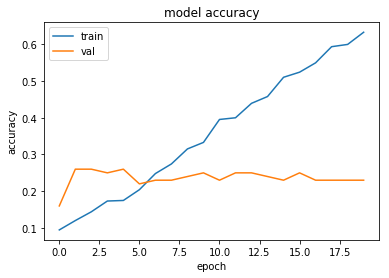

In [46]:
from matplotlib import pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

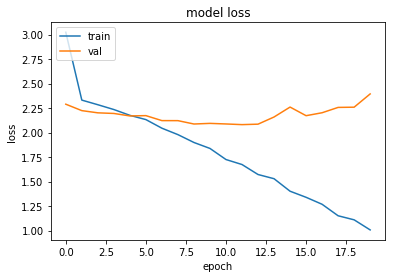

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()